In [2]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


# Simulating the a path from Brownian Motion

In [3]:
# we draw a step from [-1/2, 0, 1/2]
def draw_step():
    return (np.random.randint(3) - 1)/2, 1/3

def simulate_random_walk(dt, T, start=0):
    """
    Simulates a 1D random walk
    """
    Ws = [start] # store all positions of W
    ts = [0]
    for t in np.arange(0, T, dt):
        # draw a step
        step, _  = draw_step()
        # add step to previous
        Wt = Ws[-1] + step
        # append to the store
        Ws.append(Wt)
        ts.append(t)
        
    return Ws, ts

 Let us visualize to see how it looks:

In [4]:
Ws, ts = simulate_random_walk(0.5, 100, start=0.4)

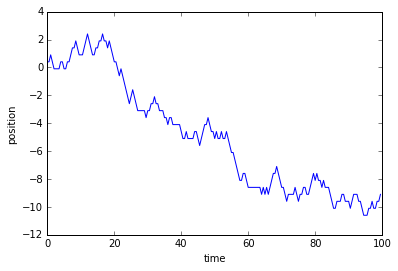

In [5]:
plt.plot(ts, Ws)
plt.ylabel('position')
plt.xlabel('time')

# Scenario

Assume that we know the particle starts around $0\pm c$, given a realization of the above process, can we find the posterior distribution of start points? i.e we want $P(W_0 | W_T)$. 

From the above we have that the transition probabilities are defined as: $P(W_{t+1} | W_t) = \frac{1}{3}$ for all outcomes of $W_{t+1}$. We can, therefore, write that 
$$P(W_0 | W_T) = \frac{P(W_T | W_0) P(W_0)}{P(W_T)}$$


We want to find $\mathbb{E}[W_0 | W_T] = \sum_{w_0} w_0 p(w_0 | w_t) dw_0 $. The Monte Carlo estimate is given by:

$$\mathbb{E}[W_0 | W_T] \approx \frac{1}{n}\sum_n w_0^{(n)}$$ where $w_0^{(n)}\sim p(w_o | w_T)$

The question now becomes: how do we sample from this posterior distribution $p(w_0 | w_T)$? From above, we have found that this posterior can be broken down. So what if we sample $w_0\sim p(w_0)$ and then plug it into $p(w_T | w_0)$?

Note that $p(w_T|w_0)=\sum_{w_{t-1}} p(w_T | w_{T-1}, w_0) p(w_{T-1} | w_0)=\ldots$

Basically what this does is sum over all possible paths from $w_0$ to $w_T$. So perhaps, we could just draw $w_0 \sim p(w_0)$ and then run the forward process to get $w_T$. Note that this can be computationally intensive because many of the paths will not lead to $w_T$:

In [125]:
# Approximate Bayesian Computation?
mc_samples = 5000
c = 2
W_T_true = Ws[-1] # the last position
w0s = []
trajectories = []
for i in range(mc_samples):
    w0 = np.random.uniform(-c, c)
    wT, _ = simulate_random_walk(0.5, 100, start=w0)
    
    #  here we accept that this path is close enough
    # if it is at most one step away from the observed.
    if np.abs(W_T_true - wT[-1]) < 0.5:
        w0s.append(w0)
        trajectories.append(wT)

w0_estimated = np.mean(w0s)
var_w0 = np.var(w0s)
print('Estimated w0:', w0_estimated, '|variance:',var_w0)

Estimated w0: -0.333526783065 |variance: 1.30498039781


In [128]:
len(w0s)/5000

0.021

(201,)
201


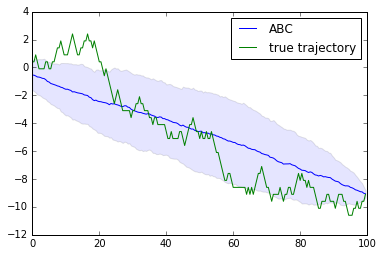

In [102]:
plot_mean_trajectories(trajectories, ts, Ws, label='ABC')

In [73]:
def plot_mean_trajectories(trajectories, ts, Ws, label='inferred'):
    mean = np.mean(trajectories, axis=0)
    std = np.std(trajectories, axis=0)
    if len(ts) < mean.shape[0]:
        mean = mean[:len(ts)]
        std = std[:len(ts)]
    print(mean.shape)
    print(len(ts))
    plt.clf()
    ax = plt.gca()
    ax.plot(ts, mean, label=label)
    ax.fill_between(ts, mean+std, mean-std, alpha=0.1)
    ax.plot(ts, Ws, color='green', label='true trajectory')
    ax.legend()
    return ax

In [52]:
# the reverse draw is the same as the forward draw.
def reverse_step():
    step, prob = draw_step()
    return -step, prob

# MC sampling
Consider that we have $\mathbb{E}[W_0 | W_T] \approx \frac{1}{n}\sum_n w_0^{(n)}$ where $w_0^{(n)}\sim p(w_o | w_T)$ what if we worked in reverse to sample from $p(w_0 | w_T)$ by leveraging the one step transition probabilities?

In [53]:
from scipy.stats import uniform

In [119]:
# MC approximation
mc_samples = 1000
c = 2
trajectories = []
W_T_true = Ws[-1] # the position we observed.
T = len(Ws)
successful_trees = 0
w0s = []
endpoints = []
for i in range(mc_samples):
    w_t = Ws[-1] # start at the end
    traj = [w_t]
    log_path_prob = 0
    
    # go in reverse time:
    for t in reversed(range(0, T)):
        
        # draw a reverse step
        # this is p(w_{t} | w_{t+1})
        step, prob = reverse_step()

        # probability of the path gets updated:
        log_path_prob += np.log(prob)
        # take the reverse step:
        w_t = w_t + step
        traj.append(w_t)

    log_path_prob += np.log(uniform.pdf(w_t, -c, c+c))
    if log_path_prob > -10**10:
        successful_trees += 1
        w0s.append(w_t)
        endpoints.append(w_t)
        trajectories.append(list(reversed(traj)))
        

successful_trees /= mc_samples

print('Estimated w0:', np.mean(w0s), '| variance:',np.var(w0s))
print(successful_trees)

/home/ml/zahmed8/.local/lib/python3.5/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log


Estimated w0: -0.111904761905 | variance: 1.21414399093
0.084


In [120]:
import random

(201,)
201


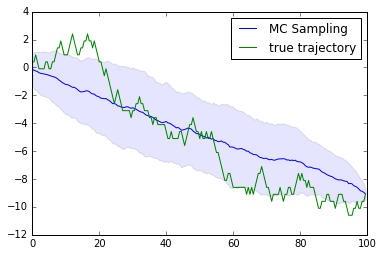

In [122]:
ax = plot_mean_trajectories(list(reversed(trajectories)), ts, Ws, label='MC Sampling')
# for traj in random.sample(trajectories, 10):
#     _ = ax.plot(ts, traj[:-1], 'x', alpha=0.2)

# Importance Sampling
75% of our reverse runs were unsucessful! What if we could be more efficient with our draws? Consider:

$$\mathbb{E}_{w_0\sim p}[w_0 | w_F] = \int w_0~p(\tau~\text{starts at}~w_0| w_F)~d\tau$$

is the integral we want to estimate where $\tau$ is a tree. Consider the reformulation:

$$\int d\tau w_0 \frac{p(\tau~\text{starts at}~w_0| w_F)}{q(\tau~\text{starts at}~w_0| w_F)}q(\tau~\text{starts at}~w_0| w_F) = \mathbb{E}_{w_0\sim q}\bigg[w_0 \frac{p(\tau~\text{starts at}~w_0| w_F)}{q(\tau~\text{starts at}~w_0| w_F)} \bigg| w_F\bigg]$$

This basically says that if we draw from a different distribution $q$, we could "correct" the probability of obtaining that result from the original distribtion $p$ so that we can get the same integral. Therefore we now have that

$$\mathbb{E}_{w_0\sim q}\bigg[w_0 \frac{p(\tau~\text{starts at}~w_0| w_F)}{q(\tau~\text{starts at}~w_0| w_F)} \bigg| w_F\bigg]\approx \frac{1}{N}\sum_{n=1}^N w_0\frac{p(\tau~\text{starts at}~w_0 | w_F)}{q(\tau~\text{starts at}~w_0| w_F)}$$

In [77]:
def p_prob_transition(step):
    if step == 0.5:
        return 1/3
    elif step == -0.5:
        return 1/3
    elif step == 0:
        return 1/3
    else:
        raise ValueError('Unknown step size!')

In [123]:
# importance sampling

def draw_from_proposal(w, time_left, push_toward=0):
#     print('pos:',w)
#     print('toward:',push_toward)
    b = 1
    probs = np.array([np.exp(b*(push_toward-w)), np.exp(b*(w-push_toward)), np.exp(0.5*b)])
    probs /= np.sum(probs)
    choices = [1/2, -1/2, 0]
    choice = np.random.choice(choices, p=probs)
    prob = probs[choices.index(choice)]
    return choice, prob


def draw_from_proposal_minimal(w, time_left, bias=0, push_toward=0):
    # We want to push slightly, such that the average step is d/T, where d is distance to 
    # the acceptable position, and T is the number of generations left. 
    sign = w/np.abs(w)
    if np.abs(w) > np.abs(push_toward):
        bias = (sign*push_toward - w)*1./time_left 
    
    
    # with probability p, pick uniform sampling; with probability 1-p, pick a step in the bias direction. 
    # expected bias is (1-p) * step_size  
    step_size = .5
    if np.abs(bias)>step_size:
        #print("will fail, might as well stop now.")
        return 0,1
    p = 1-np.abs(bias)/step_size
    bias_prob_term = np.array([0,0,0])
    if bias > 0:
        bias_prob_term[2] = 1
    if bias < 0:
        bias_prob_term[0] = 1
    choices = [-step_size,0,step_size]
    probs = np.array([p/3.,p/3.,p/3.])+ (1-p)*bias_prob_term
    choice = np.random.choice(choices, p=probs)
    prob = probs[choices.index(choice)]
    return choice, prob



trajectories = []    

mc_samples = 1000
c = 2
W_T_true = Ws[-1] # the position we observed.
T = len(Ws)
successful_trees = 0
endpoints = []
w0s = []
ones = []
for i in range(mc_samples):

    w_t = Ws[-1] # start at the end
    traj = [w_t]
    log_path_prob = 0 # use 1 because we can multiply easily
    log_q_prob = 0
    # go in reverse time:
    for t in reversed(range(0, T)):
        
        # draw a reverse step from the proposal
        step, prob = draw_from_proposal_minimal(w_t, t, push_toward=c, bias=0.1)
        log_q_prob += np.log(prob)
        # this is p(w_{t} | w_{t+1})
        log_path_prob += p_prob_transition(step)
        
        # take the reverse step:
        w_t = w_t + step
        traj.append(w_t)
    log_path_prob += np.log(uniform.pdf(w_t, -c, c+c))
    if log_path_prob > -10**10:
        successful_trees += 1
        endpoints.append(w_t)
        w0s.append(w_t * np.exp(log_path_prob - log_q_prob))
        ones.append(1 * np.exp(log_path_prob - log_q_prob))
        trajectories.append(list(reversed(traj)))

successful_trees /= mc_samples

print('Estimated w0:', np.mean(np.array(w0s)/np.mean(ones)), '| variance:',np.var(np.array(w0s)/np.mean(ones)))
print("prop, succesful trees", successful_trees)
print('True start position:', Ws[0])

/home/ml/zahmed8/.local/lib/python3.5/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/home/ml/zahmed8/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars


Estimated w0: -0.446058436765 | variance: 83.9689009114
prop, succesful trees 0.525
True start position: 0.4


(201,)
201


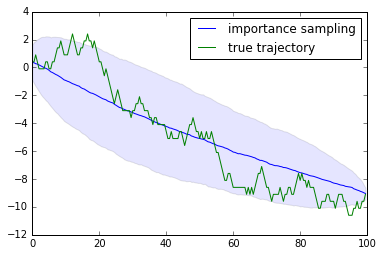

In [124]:
plot_mean_trajectories(trajectories, ts, Ws, label='importance sampling')